## <center> UNIVERSITY COLLEGE DUBLIN </center>
## <center> SCHOOL OF ELECTRICAL, ELECTRONIC & COMMUNICATIONS ENG. </center>
## <center> EEEN30150 MODELLING & SIMULATION</center>
### <center>Minor Project 1</center>
## <center>SOLUTION OF EQUATIONS BY ITERATION</center>

Report by: 


<center>James Carron:  15333196

## Dependencies
Below are all the required libraries for this project

    pip install de421
    pip install jplephem
    pip install numpy
    pip install matplotlib
    pip install cv2
    pip install time
    pip install math

In [1]:
import numpy as np
from numpy import sin,cos,exp, pi,log, log10, sqrt
np.set_printoptions(precision=6,suppress=True,threshold=10)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,3)
import matplotlib.style as plt_style
plt_style.use("ggplot")

from time import gmtime, strftime

import cv2

from jplephem import Ephemeris #used to import initial conditions
import de421 #DE421 (February 2008) — 27 MB covering years 1900 through 2050
eph = Ephemeris(de421)

from jdcal import gcal2jd #for converting a date into a JulianDay
import math #for jdcal

import time # for measure time taken for func to run

DEBUG = False

## Helper Functions

In [2]:
def date2jd(year,month,day):
    return sum(gcal2jd(year,month,day))

if DEBUG:
    print(date2jd(2018, 1, 1)) # 01-01-18 should equal 2458119.5

In [3]:
def progressbar(i, maxval):
    """prints out a progressbar so you can tell how long a program will take to run """
    scaling_val = 0.5
    percent = int(100*float(i)/maxval)
    
    val = int(percent*scaling_val)
    remainder = int(100*scaling_val)-val
    
    print("\r"+r"["+r"="*val + " "*remainder+r"] "+ "{:.0f}%".format(percent)),
    if percent == 100:
        print("\n"),

## Classes

In [21]:
class Point:
    """a class for describing a value in a 3D cartesian system [x, y, z]"""
    
    def __init__(self, x,y,z):
        self.x = x
        self.y = y
        self.z = z
        
    #### OVERLOADING OPERATORS ####
    # I probably should change this to use Numpy arrays instead as they have all the same functionality and more
    def __add__(self,other):
        x = self.x + other.x
        y = self.y + other.y
        z = self.z + other.z
        return Point(x,y,z)
    
    def __mul__(self,other):
        x = self.x * other
        y = self.y * other
        z = self.z * other
        return Point(x,y,z)
    
    def __div__(self, other):
        x = self.x / other
        y = self.y / other
        z = self.z / other
        return Point(x,y,z)
    
    def __str__(self):
        return "({: .4e},{: .4e},{: .4e})".format(self.x,self.y,self.z)

class Body:
    """ a class for summarising the properties for a body in the system """
    
    def __init__(self, body_name, body_mass, JulianDate = 2458119.5, DEBUG=False): #id_num, 
        
        self.mass = body_mass
        self.name = body_name #used for jpl ephemeris
        JPL_ephemeris(self, JulianDate,output = "store") #pull body position and vel from JPL
        
        if DEBUG:
            print("{}: \tMass: {} kg".format(self.name.capitalize(),self.mass))
            print("Pos_x: {: .4e} AU\tPos_y: {: .4e} AU\tPos_z: {: .2e} AU".format(self.pos.x, self.pos.y, self.pos.z ))
            print("Vel_x: {: .4e} AU\\s\tVel_y: {: .4e} AU\\s\tVel_z: {: .2e} AU\\s \n".format(self.vel.x, self.vel.y, self.vel.z ))

## Functions

In [5]:
def NBody_grav_accel(Bodies, target_Body, target_pos):
    """returns the total gravitation acceleration on a body due to all other bodies in a system"""
    
    AU = 149597870700 # m/Au
    G_CONST = 6.67408e-11 / (AU**3) #m3 kg-1 s-2

    total_acc = Point(0,0,0) #initialise value to 0
    
    for Body in Bodies: #calc accel due to all other bodies using superposition
        
        if Body == target_Body: #don't calculate grav accel wrt self
            continue
    
        #radial distance between the two bodies
        r = sqrt((Body.pos.x - target_pos.x)**2 + (Body.pos.y - target_pos.y)**2 + (Body.pos.z- target_pos.z)**2)
        tmp = G_CONST * Body.mass / (r**3) #store temporary value to reduce repeated calculations

        total_acc.x += tmp * (Body.pos.x - target_pos.x)
        total_acc.y += tmp * (Body.pos.y - target_pos.y)
        total_acc.z += tmp * (Body.pos.z - target_pos.z)
             
    return total_acc

In [6]:
def pntarr_to_cartesian(Bodies, interval = 1):
    """convert a point array into a standard cartesian array of the format [[x1, y1, z1], [x2, y2..."""
    
    All_Pos_Vals = list()#initialise empty array

    for body in SolarSys: 
        
        #initialise empty array
        temp_pos_array = list() 

        for i, pos in enumerate(body.pos_hist):
            if i % interval == 0:
                temp_pos_array.append([pos.x, pos.y, pos.z]) #create array entry for each time interval

        All_Pos_Vals.append(temp_pos_array) # append the positions for that body
    
    return(All_Pos_Vals)

In [22]:
def JPL_ephemeris(body, JulianDate = 2458119.5, output = "return"):

    """ Takes the name of the body and queries the JPL ephemeris data. 
    Returns the position and velocity data at a given JulianDate in m/s

    Requires:
        import de421 #DE421 (February 2008) — 27 MB covering years 1900 through 2050
        from jplephem import Ephemeris
        eph = Ephemeris(de421)

    See here for more info: https://pypi.org/project/jplephem/1.2/

    Default Julian Date: 01-01-2018"""

    """positions are returned in kilometers along the three axes of the ICRF 
    (a more precise reference frame than J2000 but oriented in the same direction)
    Velocities are returned as kilometers per day."""

    #CONSTANTS
    KM_TO_AU = 1000.0/149597900000
    KM_TO_M = 1000 # number of ms in a km        
    DAY_TO_S = 1.0/(60*60*24)

    KM_PDAY_TO_M_PS = KM_TO_M * DAY_TO_S
    KM_PDAY_TO_AU_PS = KM_TO_AU * DAY_TO_S

    #Earth does not have its own entry, instead it is calculated relatively
    if body.name == "earth":
        barycenter_pos, vel = eph.position_and_velocity("earthmoon", JulianDate)
        moonvector = eph.position('moon', JulianDate)
        pos = barycenter_pos - moonvector * eph.earth_share

    else:
        pos, vel = eph.position_and_velocity(body.name, JulianDate)

    #casts strings to floats and converts km to AU and km/day to AU/s respectively
    pos = [float(val)*KM_TO_AU for val in pos] 
    vel = [float(val)*KM_PDAY_TO_AU_PS for val in vel] 

    if output == "store":
        #unpack and set vectors
        body.pos = Point(*pos) 
        body.vel = Point(*vel)

        #save initial condition for planet
        body.pos_hist = [body.pos] 
        body.vel_hist = [body.vel]
    
    if output == "return":
        return [pos,val]

## 4th order Runge- Kutta Algorithm

In [8]:
def GravNBodyRk4(Bodies, duration, h, report_interval):
    """Takes a system of bodies and uses 4th order runge kutta and 
    newtons gravitational laws to estimate the position and 
    velocities at the next timestep"""

    number_steps = int(duration//h)
    
    for Body in Bodies:
        Body.vel_hist = [Body.vel_hist[0]]
        Body.pos_hist = [Body.pos_hist[0]]
    
    #iterate through all timesteps
    for i in range(number_steps):
        progressbar(i,number_steps-1)
        
        #iterate through all bodies
        for Body in Bodies:
            
            
            #use the previous timesteps values for the new intial conditions
            v0 = Body.vel_hist[-1] 
            p0 = Body.pos_hist[-1]

            #Initialise empty values
            k1_v = k2_v = k3_v = k4_v = Point(0,0,0)
            k1_p = k2_p = k3_p = k4_p = Point(0,0,0)

            #Calculate K coefficients
            k1_v = NBody_grav_accel(Bodies, Body, p0)
            k1_p = v0

            k2_v = NBody_grav_accel(Bodies, Body, p0 + k1_p*(h/2.0))
            k2_p = v0 + k1_v*(h/2.0)

            k3_v = NBody_grav_accel(Bodies, Body, p0 + k2_p*(h/2.0))
            k3_p = v0 + k2_v*(h/2.0)

            k4_v = NBody_grav_accel(Bodies, Body, p0 + k2_p*(h/2.0))
            k4_p = v0 + k1_v*h

            #Calculate the new values
            v1 = v0 + (k1_v + k2_v*2 + k3_v*3 + k4_v)*(h/6.0)
            p1 = p0 + (k1_p + k2_p*2 + k3_p*3 + k4_p)*(h/6.0)
            
            Body.vel_next = v1
            Body.pos_next = p1
    
        for Body in Bodies: #update the values once all the new values have be calculated
            Body.vel_hist.append(Body.vel_next)
            Body.pos_hist.append(Body.pos_next)

    output_interval = report_interval/h  
    
    All_Pos_Vals = pntarr_to_cartesian(Bodies, output_interval)

    return All_Pos_Vals

## Setup

In [9]:
Latex_Output = False
InitialCond_Output = False


EARTH_MIN = 60.0 #60s in a min
EARTH_HR = 60*EARTH_MIN #60mins in a hr
EARTH_DAY = 24*EARTH_HR #24hrs in a day
EARTH_WK = 7*EARTH_DAY #7 days in a week
EARTH_YEAR = 365*EARTH_DAY #365 days in a year

Sun     = Body("sun"    , 1.988544*(10**30))
Mercury = Body("mercury", 3.302   *(10**23))
Venus   = Body("venus"  , 48.685  *(10**23))
Earth   = Body("earth"  , 5.97219 *(10**24))
Mars    = Body("mars"   , 6.4185  *(10**23))
Jupiter = Body("jupiter", 1898.13 *(10**24))
Saturn  = Body("saturn" , 5.68319 *(10**26))
Uranus  = Body("uranus" , 86.8103 *(10**24))
Neptune = Body("neptune", 102.41  *(10**24))

SolarSys = (Sun, Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune)

## Simulation

In [10]:
duration = 1*EARTH_YEAR
timestep = 1*EARTH_DAY
report_interval = 24*EARTH_HR

All_Pos_Vals = GravNBodyRk4(SolarSys, duration, timestep, report_interval)
print("All_Pos_Vals contains {} values".format(len(All_Pos_Vals[0])))

[==================================================] 100%                    
All_Pos_Vals contains 366 values


## Exporting File

In [11]:
# use the current time within the filename
time_now = strftime("%H:%M:%S", gmtime())
output_filename = "MP2-d:{:.2f}yrs-h:{:.0f}s-i:{:.0f}-".format(duration/EARTH_YEAR, timestep, report_interval) + time_now

# save out the file
np.save("Simulation_Output/Vals/" + output_filename, All_Pos_Vals)
print("Filename: {} \t- contains {} positions".format(output_filename, len(All_Pos_Vals[0])))

Filename: MP2-d:1.00yrs-h:3600s-i:86400-15:38:56 	- contains 366 positions


## 2D Graphing

### Single Planet Orbits

In [12]:
def plotPlanet1D(Graph_body, dir1):
    
    #Find index
    for body_index, body in enumerate(SolarSys):
        if body == Graph_body:
            break
    
    #Assign index to cartesian reference
    if dir1 == "x":
        dir1_index = 0
    if dir1 == "y":
        dir1_index = 1
    if dir1 == "z":
        dir1_index = 2
    
    #Plot values
    plt.plot([val[dir1_index] for val in All_Pos_Vals[body_index]])
    plt.title("${}_{}$".format(Graph_body.name.capitalize(),dir1))
    plt.ylabel("$AU_{}$".format(dir1))
    plt.xlabel("Day")
    graph_name = "${}_{}$".format(Graph_body.name,dir1)
    plt.tight_layout()
    plt.savefig("Simulation_Output/Graphs/" + graph_name+".png")
    plt.show()
    
def plotPlanet2D(Graph_body, dir1, dir2):
    
    #Find index
    for body_index, body in enumerate(SolarSys):
        if body == Graph_body:
            break
    
    #Assign index to cartesian reference
    if dir1 == "x":
        dir1_index = 0
    if dir1 == "y":
        dir1_index = 1
    if dir1 == "z":
        dir1_index = 2
    
    if dir2 == "x":
        dir2_index = 0
    if dir2 == "y":
        dir2_index = 1
    if dir2 == "z":
        dir2_index = 2
    
    #Pull values
    dir1_vals = [val[dir1_index] for val in All_Pos_Vals[body_index]]
    dir2_vals = [val[dir2_index] for val in All_Pos_Vals[body_index]]
    
    #Plot  
    plt.plot(dir1_vals, dir2_vals)
    plt.title("${}_".format(Graph_body.name.capitalize())+r"{"+"{}{}".format(dir1,dir2) + r"}$")
    plt.xlabel("$AU_{}$".format(dir1))
    plt.ylabel("$AU_{}$".format(dir2))
    graph_name = "${}_{}{}$".format(Graph_body.name,dir1,dir2)
    plt.tight_layout()
    plt.savefig("Simulation_Output/Graphs/" + graph_name+".png")
    plt.show()

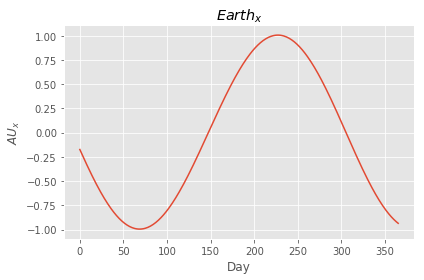

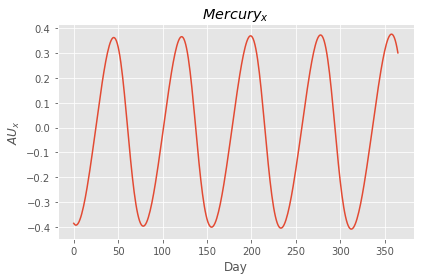

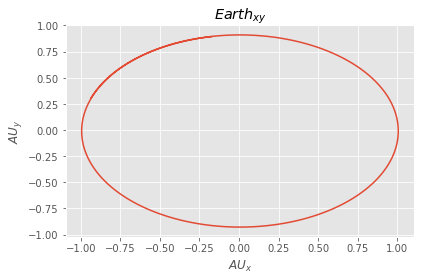

In [13]:
plotPlanet1D(Earth,"x")
plotPlanet1D(Mercury, "x")

plotPlanet2D(Earth, "x", "y")

### System Orbits

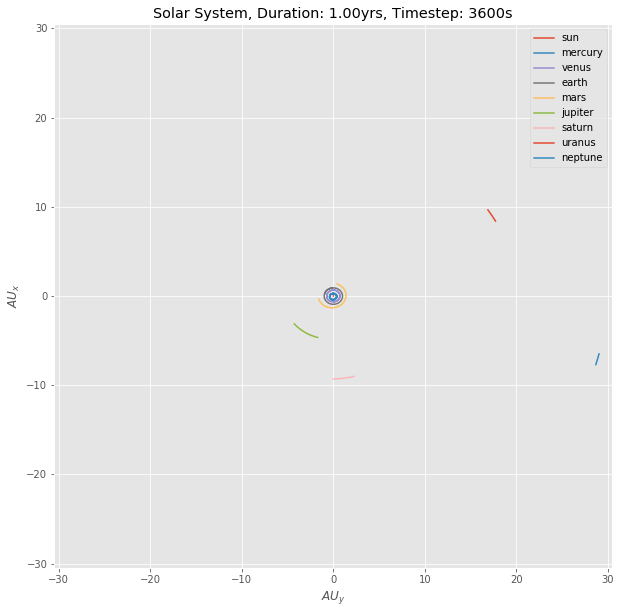

In [14]:
All_Pos_Vals = np.load("Simulation_Output/Vals/" + output_filename + ".npy") #load last 

#Plot Graph

max_range = 0
max_range_scaling = 1.05

plt.figure(figsize=(10,10))

for body in SolarSys:

    bodyx = [ val.x for val in body.pos_hist]
    bodyy = [ val.y for val in body.pos_hist]  
    
    plt.plot(bodyx, bodyy,label = body.name)

    max_dim = abs(max(max(bodyx,key=abs),max(bodyy,key=abs),key=abs))
    if max_dim > max_range:
        max_range = max_dim
            
    plt.xlim([-max_range*max_range_scaling,max_range*max_range_scaling])    
    plt.ylim([-max_range*max_range_scaling,max_range*max_range_scaling])

plt.ylabel("$AU_x$")
plt.xlabel("$AU_y$")
plt.legend()
plt.title("Solar System, Duration: {:.2f}yrs, Timestep: {:.0f}s".format(duration/EARTH_YEAR, timestep))    
plt.savefig("Simulation_Output/Graphs/" + output_filename+".png")
plt.show()

## 2D Animation

In [15]:
#Animate
num_planets = 3
max_range = 0
max_range_scaling = 1.05

plt.figure(figsize=(10,10))


anim_len = len(All_Pos_Vals[0])
length = 5*(duration/EARTH_YEAR) #length in seconds
fps = 60 #fps of video

num_frames = int(length*fps)
frame_interval = int(anim_len/num_frames)

Anim_folder = "Simulation_Output/Animation/Frames/"
Vid_folder = "Simulation_Output/Animation/"

print("Generating Frames:")

for i in range(1,num_frames):
    progressbar(i,num_frames-1)

    
    for body in SolarSys[:num_planets]:

        bodyx = [ val.x for val in body.pos_hist[0:i*frame_interval:frame_interval]]
        bodyy = [ val.y for val in body.pos_hist[0:i*frame_interval:frame_interval]]  

        plt.plot(bodyx, bodyy,label = body.name)

        max_dim = abs(max(max(bodyx,key=abs),max(bodyy,key=abs),key=abs))
        if max_dim > max_range:
            max_range = max_dim

        plt.xlim([-max_range*max_range_scaling,max_range*max_range_scaling])    
        plt.ylim([-max_range*max_range_scaling,max_range*max_range_scaling])

    plt.ylabel("$AU_x$")
    plt.xlabel("$AU_y$")
    plt.legend()
    plt.title("Solar System, Duration: {:.2f}yrs, Timestep: {:.0f}s".format(duration/EARTH_YEAR, timestep))    
    plt.savefig(Anim_folder+str(i)+".png")
    plt.clf()
plt.close()
print("\nGenerating Video:")    
    
fourcc = cv2.VideoWriter_fourcc(*'XVID')
initial_img = cv2.imread(Anim_folder+"1.png")
height , width , layers =  initial_img.shape

time_now = strftime("%H:%M:%S", gmtime()) 

vid_filename = Vid_folder + 'SolarSys_{}_Duration:{:.2f}yrs,Timestep:{:.0f}s.avi'.format(time_now, duration/EARTH_YEAR, timestep)
video = cv2.VideoWriter(vid_filename,fourcc,fps,(width,height))

#write all frames into a video
for i in range(num_frames):
    progressbar(i,num_frames-1)
    img = cv2.imread(Anim_folder+str(i)+".png")
    video.write(img)

cv2.destroyAllWindows()
video.release()

print("Video Filename: " + vid_filename)

Generating Frames:
[==================================================] 100%                                                                                                                                                                          

Generating Video:
[==================================================] 100%               
Video Filename: Simulation_Output/Animation/SolarSys_15:39:58_Duration:1.00yrs,Timestep:3600s.avi


## Func's for Report

In [16]:
#Outputs the initial conditions in a form suitable to create a table in Latex

if Latex_Output:
    print(r"\hline")
    print(r" & \textbf{Position (AU): }& \textbf{Vel (\sfrac{AU}{s}): }\\")
    AUs_unit = "\sfrac{AU}{s}"

    for self in SolarSys:
            print(r"\hline")
            print(r"\textbf{" + "{}".format((self.name.capitalize())) + r"}" + ": \t& &{} kg ".format(self.mass)+r"\\")
            print(r"\hline")
            print("x: \t& {: .2e} \t& {: .2e}".format(self.pos.x, self.vel.x) +r"\\")
            print("y: \t& {: .2e} \t& {: .2e}".format(self.pos.y, self.vel.y) +r"\\")
            print("z: \t& {: .2e} \t& {: .2e}".format(self.pos.z, self.vel.z) +r"\\")
    print(r"\hline")

#Outputs the initial conditions as provided by the JPL Api
if InitialCond_Output:
    JulianDate = 2458119.5

    for body in SolarSys:
        if body.name != "earth":
            pos, vel = eph.position_and_velocity(body.name, JulianDate)
            pos = [float(val) for val in pos]
            vel = [float(val) for val in vel]
            print("{}: ".format(body.name.capitalize()))
            print("Pos [x y z]: {: e},{: e},{: e}".format(pos[0],pos[1],pos[2]))
            print("Vel [x y z]: {: e},{: e},{: e}\n".format(vel[0],vel[1],vel[2]))

## Error Graphs
### Pulling Actual Values from JPL Ephemeris

In [24]:
#pulling the actual values

actual_vals = list()

for body_index, body in enumerate(SolarSys):
    
    body_actual_vals = list()
    for i in range(0,365): #loop through all the days
        pos , vel = JPL_ephemeris(body, date2jd(2018, 1, i+1)) #pull the pos value per day
        body_actual_vals.append(pos)
    
    actual_vals.append(body_actual_vals)

### Simulation Results

In [34]:
duration = 1*EARTH_YEAR
output_interval = 1*EARTH_DAY
eval_duration = list()

timestep_vals = (15*EARTH_MIN, 1*EARTH_HR, 6*EARTH_HR, EARTH_DAY) 
measured_vals = list() # measured_vals[timestep_index][planet_index][value_index][component_index]

for timestep_index, timestep in enumerate(timestep_vals): #check each timestep
    print("Timestep: {:.2f}hrs".format(timestep/EARTH_HR))
    
    start = time.clock()
    measured_vals.append( GravNBodyRk4(SolarSys, duration, timestep, output_interval) )
    eval_duration.append(time.clock() - start)
    
    print("Time Elapsed: {:.2f}s".format(eval_duration[timestep_index]))

Timestep: 0.25hrs
[==================================================] 100%                                                                                                    
Time Elapsed: 133.90s
Timestep: 1.00hrs
[==================================================] 100%                        
Time Elapsed: 34.02s
Timestep: 6.00hrs
[==================================================] 100%    
Time Elapsed: 5.06s
Timestep: 24.00hrs
[==================================================] 100% 
Time Elapsed: 1.27s


## Latex Output

In [40]:
if Latex_Output:
    for timestep_index, timestep in enumerate(timestep_vals):
        print("{:.2f} &{:.2f}\% &{:.2f}\\\\".format(timestep_vals[timestep_index]/EARTH_HR, avg_error[3-timestep_index]/len(SolarSys), eval_duration[timestep_index]/max(eval_duration)))

## Error Graphs

/home/james/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0.25hrs: 	Average Error: 0.33% 	Time Taken:133.90s
1.00hrs: 	Average Error: 0.37% 	Time Taken:34.02s
6.00hrs: 	Average Error: 0.56% 	Time Taken:5.06s
24.00hrs: 	Average Error: 0.55% 	Time Taken:1.27s


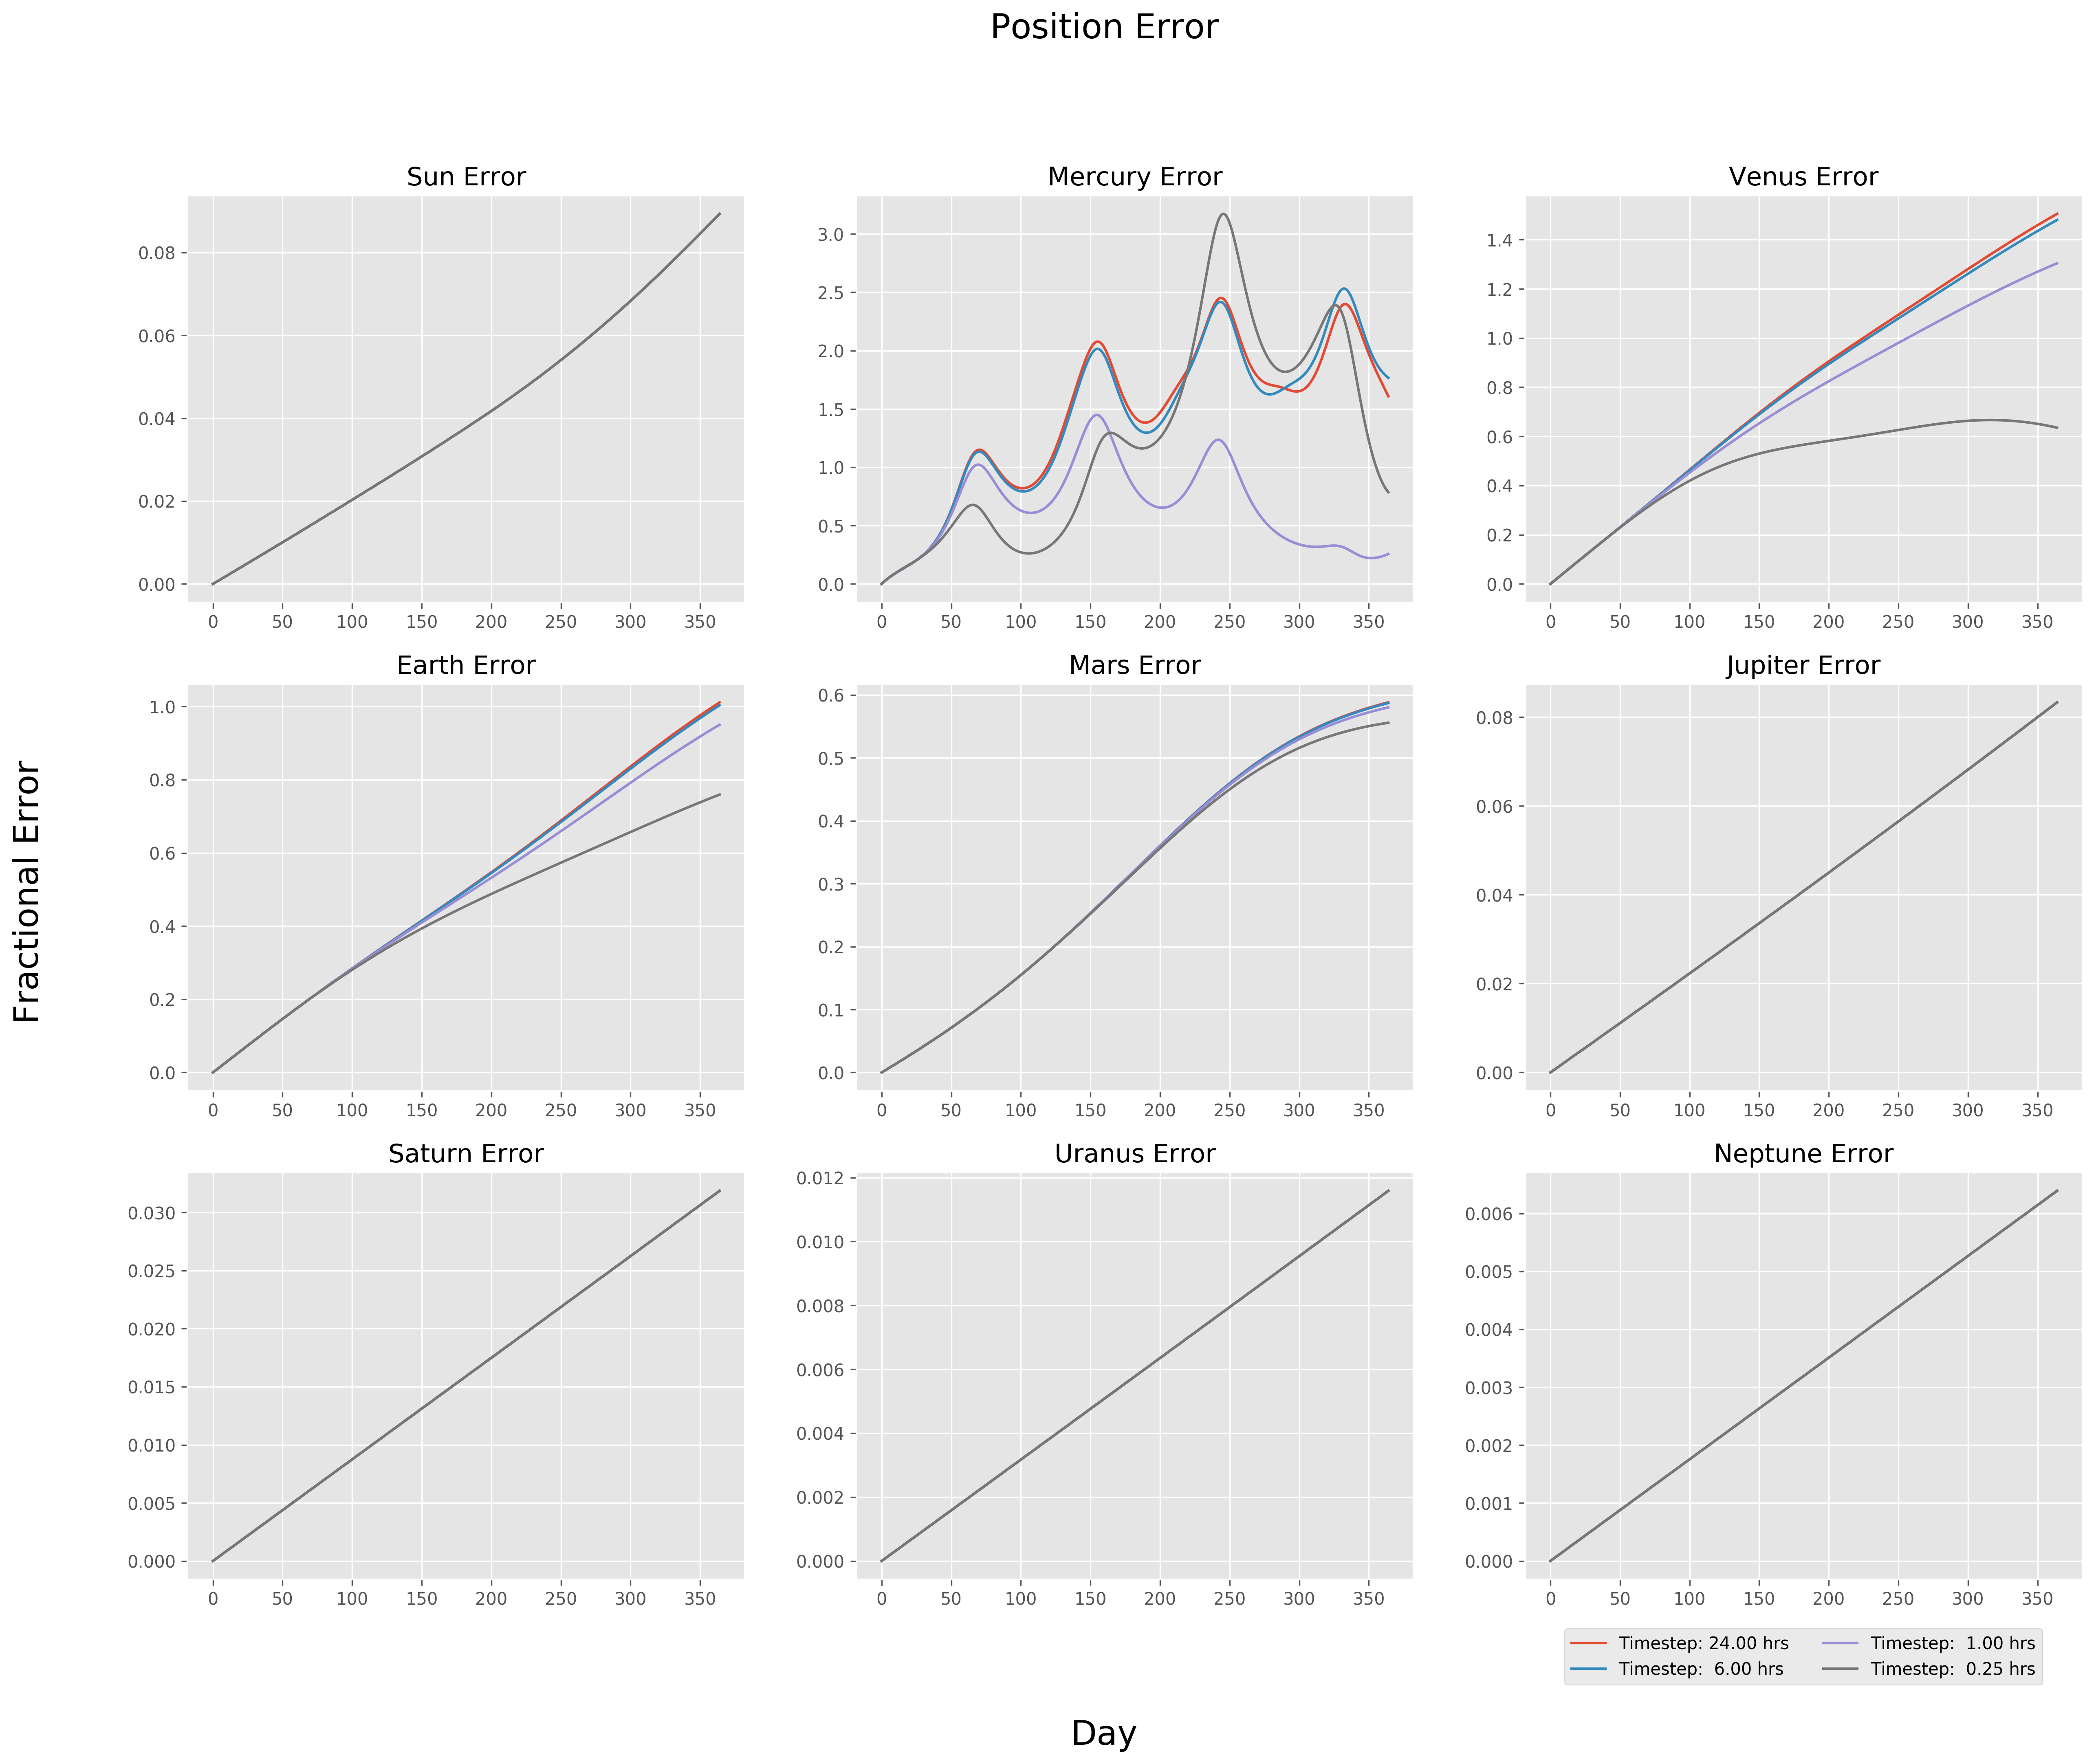

In [35]:
day_start = 0
day_end = -1
avg_error = [0 for timestep in timestep_vals]

fig = plt.figure(figsize=(20, 15),dpi=300) #create plot
fig.suptitle('Position Error', fontsize = 20)

#Label the X and Y Axis
fig.text(0.5, 0.04, "Day", ha='center', va='center', fontsize = 20)
fig.text(0.06, 0.5, "Fractional Error", ha='center', va='center', rotation='vertical', fontsize = 20)

for planet_index, body in enumerate(SolarSys): #graph for all planets

    for timestep_index, timestep in enumerate(timestep_vals): #for each timestep
        timestep_error = list()

        for value_index, value in enumerate(measured_vals[timestep_index][planet_index][day_start:day_end]): #for each val of planet
            actual_val = actual_vals[planet_index][value_index]

            error = sqrt( ((value[0]-actual_val[0])**2) + ((value[1]-actual_val[1])**2) + ((value[2]-actual_val[2])**2) )
            total_error = (error / sqrt( (actual_val[0]**2) + (actual_val[1]**2) + (actual_val[2]**2) ))
            
            timestep_error.append(total_error)
        
        #Plotting the values
        sub = fig.add_subplot(3,3,planet_index+1) # create a set of 3x3 plots, current fig is at index[i]
        sub.set_title("{} Error".format(body.name.capitalize()),fontsize = 15)
        sub.plot(timestep_error,label = "Timestep: {:5.2f} hrs".format(timestep_vals[3-timestep_index]/EARTH_HR))
        avg_error[timestep_index] += total_error

# Do some cool #### with the legend
art = []
sub = fig.add_subplot(3,3,9)
lgd = plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
art.append(lgd)   

output_filename ="Error_Day_{}_to_365".format(day_start) 
plt.savefig("Simulation_Output/Graphs/ErrorAnalysis/" + output_filename + ".png", additional_artists=art,    bbox_inches="tight")
#plt.show()

for timestep_index, timestep in enumerate(timestep_vals):
    print("{:.2f}hrs: \tAverage Error: {:.2f}% \tTime Taken:{:.2f}s".format(timestep_vals[timestep_index]/EARTH_HR, avg_error[3-timestep_index]/len(SolarSys), eval_duration[timestep_index]))
    
    

## Results in Latex Format

## Individual Error Graphs

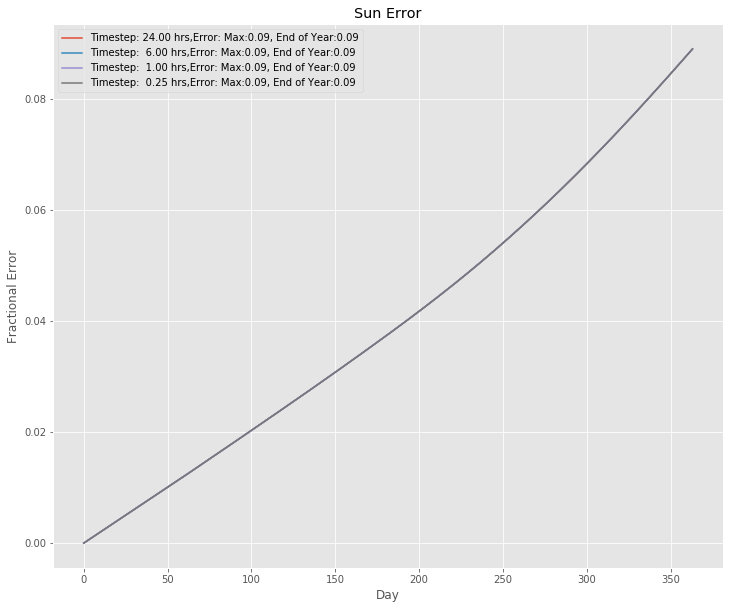

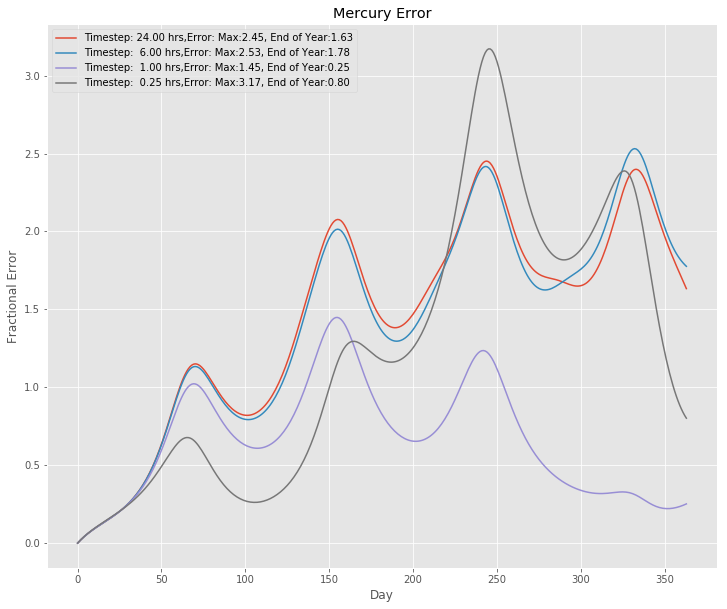

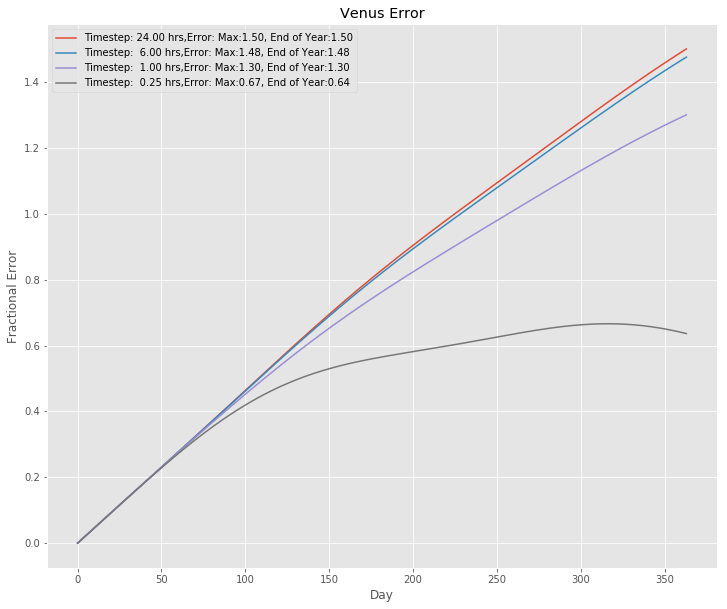

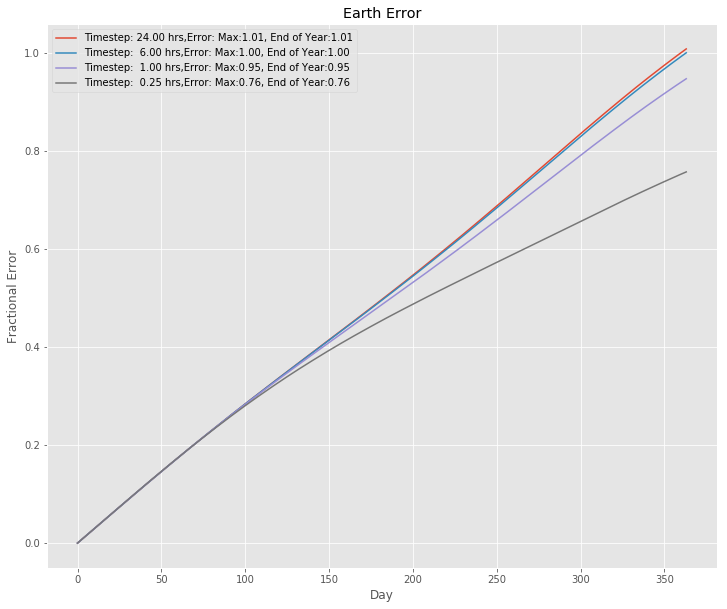

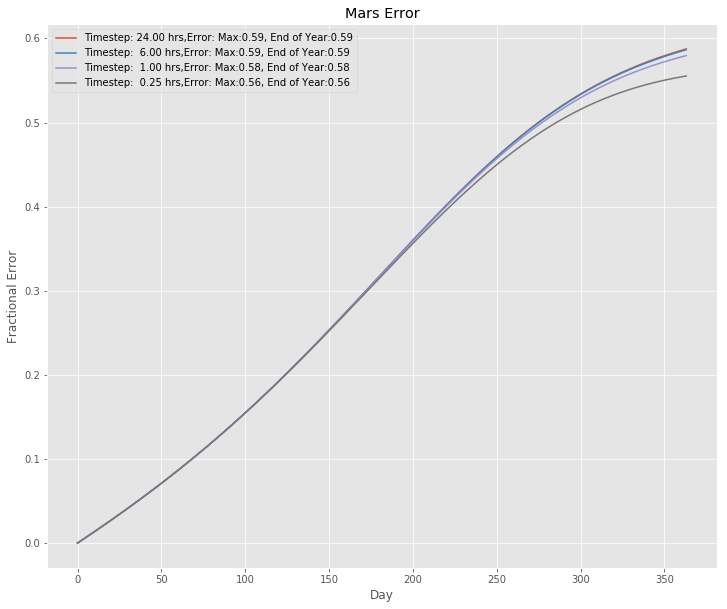

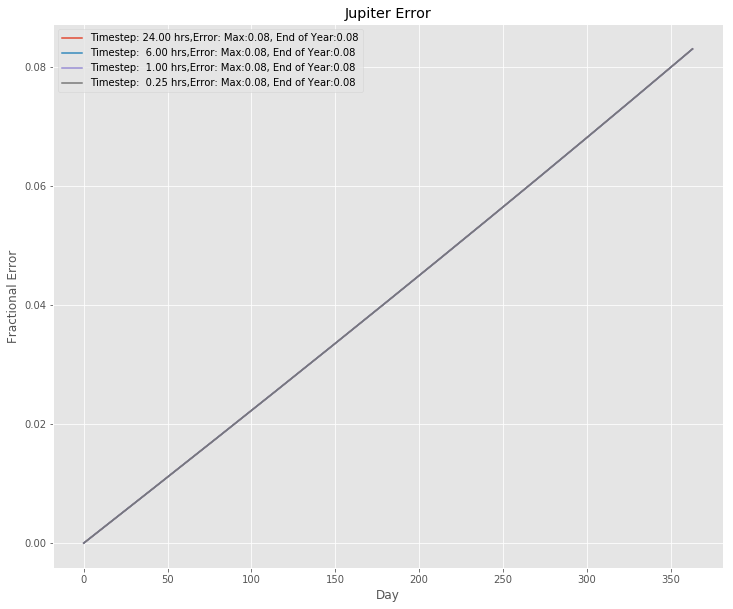

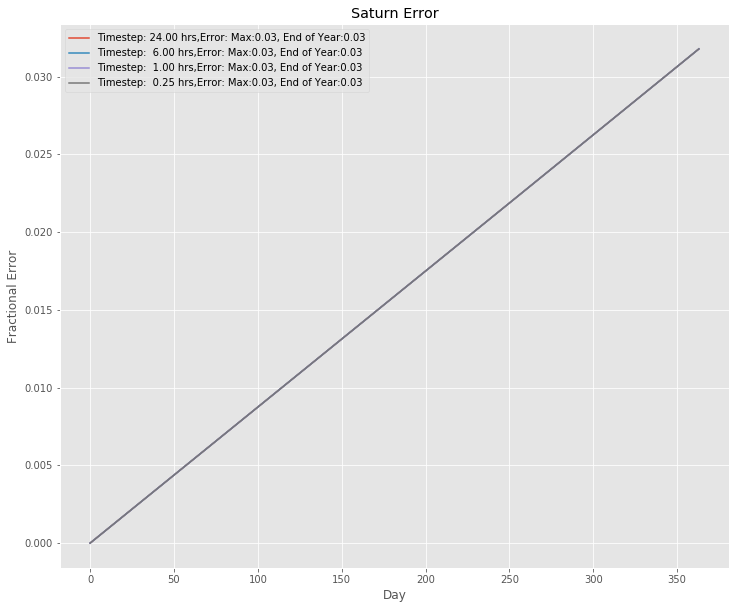

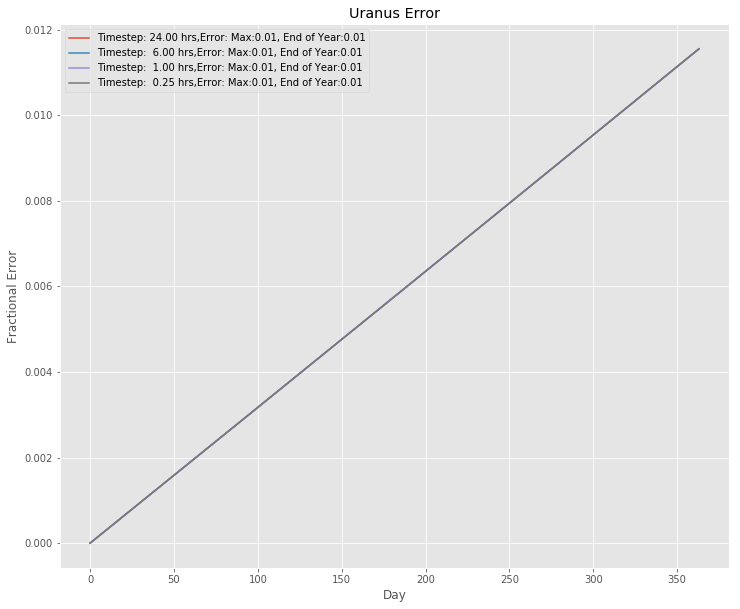

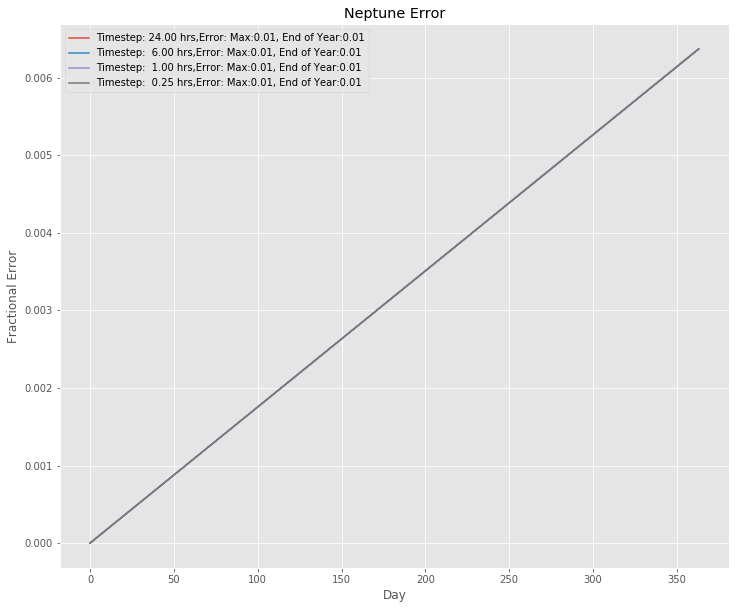

0.25hrs: 	Average Error: 0.55% 	Time Taken:133.90s
1.00hrs: 	Average Error: 0.56% 	Time Taken:34.02s
6.00hrs: 	Average Error: 0.37% 	Time Taken:5.06s
24.00hrs: 	Average Error: 0.33% 	Time Taken:1.27s


In [37]:
day_start = 0
day_end = -2
avg_error = [0 for timestep in timestep_vals]


for planet_index, body in enumerate(SolarSys): #graph for all planets
    plt.figure(figsize = (12,10))
    for timestep_index, timestep in enumerate(timestep_vals): #for each timestep
        timestep_error = list()

        for value_index, value in enumerate(measured_vals[timestep_index][planet_index][day_start:day_end]): #for each val of planet
            actual_val = actual_vals[planet_index][value_index]

            error = sqrt( (value[0]-actual_val[0])**2 + (value[1]-actual_val[1])**2 + (value[2]-actual_val[2])**2 )
            total_error = (error / sqrt( (actual_val[0]**2) + (actual_val[1]**2) + (actual_val[2]**2) ))
            
            timestep_error.append(total_error)
        
        plt.plot(timestep_error,label = "Timestep: {:5.2f} hrs,Error: Max:{:.2f}, End of Year:{:.2f}".format(timestep_vals[3-timestep_index]/EARTH_HR,max(timestep_error),timestep_error[-1]))
        avg_error[timestep_index] += total_error
    plt.title("{} Error".format(body.name.capitalize()))
    plt.xlabel("Day")
    plt.ylabel("Fractional Error")
    plt.legend()
    output_filename ="{}:_Error_Day_{}_to_365".format(body.name.capitalize(), day_start) 
    plt.savefig("Simulation_Output/Graphs/ErrorAnalysis/" + output_filename + ".png")
    plt.show()

for timestep_index, timestep in enumerate(timestep_vals):
    print("{:.2f}hrs: \tAverage Error: {:.2f}% \tTime Taken:{:.2f}s".format(timestep/EARTH_HR, avg_error[timestep_index]/len(SolarSys), eval_duration[timestep_index]))
    
    